# FGSM网络对抗攻击

[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r2.0.0-alpha/tutorials/application/zh_cn/cv/mindspore_fgsm.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/r2.0.0-alpha/tutorials/application/zh_cn/cv/mindspore_fgsm.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/r2.0.0-alpha/tutorials/application/source_zh_cn/cv/fgsm.ipynb)

近年来随着数据、计算能力、理论的不断发展演进，深度学习在图像、文本、语音、自动驾驶等众多领域都得到了广泛应用。与此同时，人们也越来越关注各类模型在使用过程中的安全问题，因为AI模型很容易受到外界有意无意的攻击而产生错误的结果。

在本案例中，我们将以梯度符号攻击（Fast Gradient Sign Method，FGSM）为例，演示此类攻击是如何误导模型的。

## 对抗样本定义

Szegedy在2013年最早提出对抗样本的概念：

在原始样本处加入人类无法察觉的微小扰动，使得深度模型性能下降，这种样本即对抗样本。如下图所示，本来预测为“panda”的图像在添加噪声之后，模型就将其预测为“gibbon”，右边的样本就是一个对抗样本：

![fgsm-panda-image](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/tutorials/application/source_zh_cn/cv/images/panda.png)

> 图片来自[Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)。

## 攻击方法

对模型的攻击方法在宏观层面可以从如下两个方面进行分类：

1. 攻击者掌握的信息多少：

   - **白盒攻击**：攻击者具有对模型的全部知识和访问权限，包括模型结构、权重、输入、输出，在产生对抗性攻击数据的过程中能够与模型系统有所交互。由于模型的信息完全被攻击者掌握，攻击者可以针对被攻击模型的特性设计特定的攻击算法。

   - **黑盒攻击**：与白盒攻击相反，攻击者仅具有关于模型的有限知识。攻击者对模型的结构权重一无所知，仅了解部分输入输出。

2. 攻击者的目的：

   - **有目标的攻击**：攻击者将模型结果误导为特定分类。

   - **无目标的攻击**：攻击者只想产生错误结果，而不在乎新结果是什么。

本案例中用到的梯度符号攻击FGSM是一种白盒攻击方法，既可以是有目标也可以是无目标攻击。

> 更多的模型安全功能可参考[MindArmour](https://www.mindspore.cn/mindarmour)，现已支持FGSM、LLC、Substitute Attack等多种对抗样本生成方法，并提供对抗样本鲁棒性模块、Fuzz Testing模块、隐私保护与评估模块，帮助用户增强模型安全性。

### 快速梯度符号攻击（FGSM）

分类网络的训练会定义一个损失函数，用于衡量模型输出值与样本真实标签的距离，通过反向传播计算模型梯度，梯度下降更新网络参数，减小损失值，提升模型精度。

FGSM（Fast Gradient Sign Method）是一种简单高效的对抗样本生成方法。不同于正常分类网络的训练过程，FGSM通过计算loss对于输入的梯度为 $\nabla_x J(\theta ,x ,y)$，梯度表征了loss对于输入变化的敏感性。

然后在原始输入加上上述梯度，使得loss增大，导致模型对于改造后的输入样本分类效果变差，从而达到攻击效果。

对抗样本的另一要求是生成样本与原始样本的差异要尽可能的小，使用sign函数可以使得修改图片时尽可能的均匀。

产生的对抗扰动用公式可以表示为：

$$ \eta  = \varepsilon  sign(\nabla_x  J(\theta)) \tag{1}$$

对抗样本可公式化为：

$$ x' = x + \varepsilon sign(\nabla_x J(\theta ,x ,y)) \tag{2}$$

其中，

- $x$：正确分类为“Pandas”的原始输入图像。
- $y$：是$x$的输出。
- $\theta$：模型参数。
- $\varepsilon$：攻击系数。
- $J(\theta, x, y)$：训练网络的损失。
- $\nabla_x  J(\theta)$：反向传播梯度。

## 数据处理

本案例将使用MNIST训练一个精度达标的LeNet网络，然后运行上文中所提到的FGSM攻击方法，达到欺骗网络模型，让模型实现错误分类的效果。

以下示例代码将数据集下载并解压到指定位置。

In [19]:
import mindspore.dataset.vision as transforms
from mindspore.dataset.vision import Inter
from mindspore.dataset import MnistDataset

dataset_train = MnistDataset(dataset_dir="./mnist_dataset", usage="train", shuffle=True)
dataset_eval = MnistDataset(dataset_dir="./mnist_dataset", usage="test", shuffle=True)

trans_transform = [
    transforms.Resize(size=32, interpolation=Inter.LINEAR),
    transforms.Rescale(1.0 / 255.0, 0.0),
    transforms.Rescale(1 / 0.3081, -1 * 0.1307 / 0.3081),
    transforms.HWC2CHW(),
]

dataset_train = dataset_train.map(operations=trans_transform, input_columns=["image"])
dataset_train = dataset_train.map(operations=lambda x: x.astype("int32"), input_columns=["label"])
dataset_train = dataset_train.batch(batch_size=32, drop_remainder=True)

dataset_eval = dataset_eval.map(operations=trans_transform, input_columns=["image"])
dataset_eval = dataset_eval.map(operations=lambda x: x.astype("int32"), input_columns=["label"])
dataset_eval = dataset_eval.batch(batch_size=32, drop_remainder=True)

下载的数据集文件的目录结构如下：

```text
.
└── mnist_dataset
    ├── t10k-images-idx3-ubyte
    ├── t10k-labels-idx1-ubyte
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```

## 训练LeNet网络

实验中使用LeNet作为演示模型完成图像分类，这里先定义网络并使用MNIST数据集进行训练。

定义LeNet网络：

In [6]:
from mindspore import nn
from mindspore.common.initializer import Normal


class LeNet5(nn.Cell):
    """LeNet5"""
    def __init__(self, num_classes=10, num_channel=1, include_top=True):
        super(LeNet5, self).__init__()
        self.include_top = include_top

        self.conv1 = nn.Conv2d(num_channel, 6, 5, pad_mode='valid')
        self.conv2 = nn.Conv2d(6, 16, 5, pad_mode='valid')
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        if self.include_top:
            self.flatten = nn.Flatten()
            self.fc1 = nn.Dense(16 * 5 * 5, 120, weight_init=Normal(0.02))
            self.fc2 = nn.Dense(120, 84, weight_init=Normal(0.02))
            self.fc3 = nn.Dense(84, num_classes, weight_init=Normal(0.02))

    def construct(self, x):
        """
        LeNet5 construct.
        """
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        if self.include_top:
            x = self.flatten(x)
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.fc3(x)
        return x


network = LeNet5()

定义优化器与损失函数：

In [7]:
import mindspore.nn as nn

net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
net_opt = nn.Momentum(network.trainable_params(), learning_rate=0.01, momentum=0.9)

定义网络参数：

In [8]:
from mindspore import train

config_ck = train.CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)
ckpoint = train.ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)

训练LeNet网络：

In [9]:
from mindspore import LossMonitor
import mindspore as ms

model = ms.Model(network, loss_fn=net_loss, optimizer=net_opt, metrics={'accuracy'})
model.train(5, dataset_train, callbacks=[ckpoint, LossMonitor(1875)])

epoch: 1 step: 1875, loss is 0.022706642746925354
epoch: 2 step: 1875, loss is 0.11357966810464859
epoch: 3 step: 1875, loss is 0.011764582246541977
epoch: 4 step: 1875, loss is 0.014187423512339592
epoch: 5 step: 1875, loss is 0.0022521568462252617


测试此时的网络，可以观察到LeNet已经达到比较高的精度：

In [11]:
acc = model.eval(dataset_eval)
print("{}".format(acc))

{'accuracy': 0.9887820512820513}


加载已经训练好的LeNet模型：

In [10]:
param_dict = ms.load_checkpoint("checkpoint_lenet-5_1875.ckpt")
ms.load_param_into_net(network, param_dict)

[]

### 实现FGSM

在得到精准的LeNet网络之后，下面将会采用FSGM攻击方法，在图像中加载噪声后重新进行测试。

先通过损失函数求取反向梯度：

In [12]:
def forward_fn(inputs, targets):
    out = network(inputs)
    loss = net_loss(out, targets)
    return loss

然后根据公式（2）实现FGSM攻击：

In [13]:
import numpy as np


def gradient_func(inputs, labels):
    _grad_all = ops.composite.GradOperation(get_all=True, sens_param=False)
    # 求取梯度
    out_grad = _grad_all(forward_fn)(inputs, labels)[0]
    gradient = out_grad.asnumpy()
    gradient = np.sign(gradient)
    return gradient


def generate(inputs, labels, eps):
    # 实现FGSM
    inputs_tensor = ms.Tensor(inputs)
    labels_tensor = ms.Tensor(labels)
    gradient = gradient_func(inputs_tensor, labels_tensor)
    # 产生扰动
    perturbation = eps * gradient
    # 生成受到扰动的图片
    adv_x = inputs + perturbation
    return adv_x


def batch_generate(inputs, labels, eps, batch_size):
    # 对数据集进行处理
    arr_x = inputs
    arr_y = labels
    len_x = len(inputs)
    batches = int(len_x / batch_size)
    res = []
    for i in range(batches):
        x_batch = arr_x[i * batch_size: (i + 1) * batch_size]
        y_batch = arr_y[i * batch_size: (i + 1) * batch_size]
        adv_x = generate(x_batch, y_batch, eps=eps)
        res.append(adv_x)
    adv_x = np.concatenate(res, axis=0)
    return adv_x


再次处理MINIST数据集中测试集的图片：

In [14]:
images = []
labels = []
test_images = []
test_labels = []
predict_labels = []

ds_test = dataset_eval.create_dict_iterator(output_numpy=True)

for data in ds_test:
    images = data['image'].astype(np.float32)
    labels = data['label']
    test_images.append(images)
    test_labels.append(labels)
    pred_labels = np.argmax(model.predict(ms.Tensor(images)).asnumpy(), axis=1)
    predict_labels.append(pred_labels)

test_images = np.concatenate(test_images)
predict_labels = np.concatenate(predict_labels)
true_labels = np.concatenate(test_labels)

## 运行攻击

由FGSM攻击公式中可以看出，攻击系数$\varepsilon$越大，对梯度的改变就越大。当$\varepsilon$ 为零时则攻击效果不体现。

$$\eta = \varepsilon sign(\nabla_x  J(\theta)) \tag{3}$$

现在先观察当$\varepsilon$为零时的攻击效果：

In [16]:
import mindspore.ops as ops

advs = batch_generate(test_images, true_labels, batch_size=32, eps=0.0)

adv_predicts = model.predict(ms.Tensor(advs)).asnumpy()
adv_predicts = np.argmax(adv_predicts, axis=1)
accuracy = np.mean(np.equal(adv_predicts, true_labels))
print(accuracy)

0.9887820512820513


再将$\varepsilon$设定为0.5，尝试运行攻击：

In [17]:
advs = batch_generate(test_images, true_labels, batch_size=32, eps=0.5)

adv_predicts = model.predict(ms.Tensor(advs)).asnumpy()
adv_predicts = np.argmax(adv_predicts, axis=1)
accuracy = np.mean(np.equal(adv_predicts, true_labels))
print(accuracy)

0.30138221153846156


从上面的打印结果可以看出，此时LeNet模型的精度大幅降低。

下面演示受攻击照片现在的实际形态，可以看出图片只是发生了很小的变化，然而在精度测试中却严重下降：

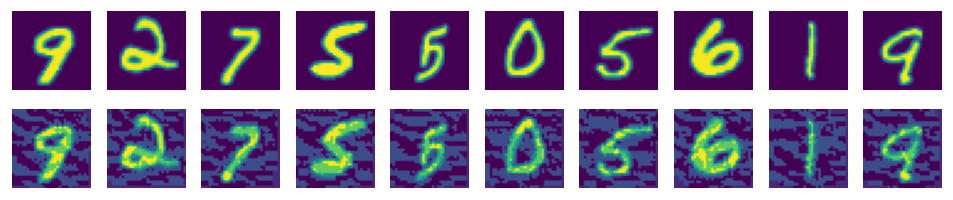

In [18]:
import matplotlib.pyplot as plt
% matplotlib inline

adv_examples = np.transpose(advs[:10], [0, 2, 3, 1])
ori_examples = np.transpose(test_images[:10], [0, 2, 3, 1])

plt.figure(figsize=(10, 3), dpi=120)
for i in range(10):
    plt.subplot(3, 10, i + 1)
    plt.axis("off")
    plt.imshow(np.squeeze(ori_examples[i]))
    plt.subplot(3, 10, i + 11)
    plt.axis("off")
    plt.imshow(np.squeeze(adv_examples[i]))
plt.show()